In [1]:
import pandas as pd
import numpy as np

all_df = pd.read_excel('TrainDataset2024.xls', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


### Data Imputation

In [2]:
'''
Strategy: 
We trained a logistic regression model to predict the missing gene values.
see the training for this model in train_gene_classifier.ipynb

steps:
1. Imputer missing Gene with gene_classifier predictions
2. Impute missing values in all other columns with median 
'''

import pickle
from sklearn.impute import SimpleImputer

'''
Load the features that were used in the training of the gene classifier.

The gene_clf_selected_features.json file is created in train_gene_classifier.ipynb
'''
import json
keep_feat_names = []
with open('gene_clf_selected_features.json', 'rb') as f:
  keep_feat_names = json.load(f)
  
# Step 1. Imputer missing Gene with gene_classifier predictions
# load the gene classifier model
with open('log_reg_gene_classifier.pkl', 'rb') as f:
  log_res_clf = pickle.load(f)
  
  # Get row indicies of missing gene values
  gene_impute_df = all_df.copy()
  temp_X = gene_impute_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)
  y = gene_impute_df['Gene']
  keep_df = temp_X[keep_feat_names]
  replace_index = keep_df[keep_df['Gene'] == 999].index

  print("Before Impute:")
  print(gene_impute_df.iloc[replace_index, :]['Gene'][:3])

  # shape the target data set
  target = gene_impute_df.loc[replace_index, keep_feat_names]
  target.drop('Gene', axis=1, inplace=True)

  # make classification predictions
  pred = log_res_clf.predict(target)
  # replace missing gene values with predictions
  gene_impute_df.loc[replace_index, 'Gene'] = pred

  print("After Impute:") 
  print(gene_impute_df.iloc[replace_index, :]['Gene'][:3])

  # assign the gene values back to the main dataframe
  all_df['Gene'] = gene_impute_df['Gene']

# Step 2. Impute missing values in all other columns with median
# Replace missing values with median of the column
imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

Before Impute:
28     999
123    999
161    999
Name: Gene, dtype: int64
After Impute:
28     0
123    0
161    0
Name: Gene, dtype: int64


/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [3]:
# Save regression target label for later use
y = all_df['RelapseFreeSurvival (outcome)']

### Outlier Removal

In [4]:
from outlier_removal import removeOutliers

'''
# Outlier detection using the following methods:
# 1. Percentile based outlier detection
# 2. MAD (median absolute deviation) based outlier detection
# 3. Standard deviation based outlier detection

# Implemented in outlier_removal.py file - see for more details 
'''

removeOutliers(all_df)
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

### Data Normalisation
Skip data normalization becasue tree-based model that's insensitive to the scaling of features.

### Feature Selection and Dimensionality Reduction

In [5]:
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
'''
  Feature Selection and Dimensionality Reduction strategy:
  Combine the following feature categories:
    1. Mandatory features - 'ER', 'HER2', 'Gene'
    2. Select the nomral MRI features and apply PCA
    3. Select the best features from the rest of the features (non MRI)
  Then combine all the selected features and apply PCA to reduce the dimensionality of the final feature set.
'''

# A dictionary for storing columns names used during training for the final test predictions
cache = {} 

# 1. Mandarory feartures
mandatory_features_indices = [1,3,10]
print(f"Mandatory features: {X.columns[mandatory_features_indices]}")

# 2. Normally distributed MRI features and apply PCA
mri_indices = list(range(11, X.shape[1]))
mri_features = X.iloc[:, mri_indices]
alpha = 0.05
normal_cols_idx = []
for idx, col in enumerate(mri_features.columns):
  res = stats.normaltest(mri_features[col])
  if res.pvalue > alpha:
    normal_cols_idx.append(idx)
print(f"Normal MRI features: {list(mri_features.columns[normal_cols_idx])}")

# Apply PCA to the MRI features
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_mri = X.iloc[:, normal_cols_idx]
X_mri_pca = pca.fit_transform(X_mri)
print(f"Normal MRI PCA shape: {X_mri_pca.shape}")

# save normally distributed MRI features index
cache['normal_cols_idx'] = list(normal_cols_idx)

# 3. Select best features from the rest of the features
# Start by selectinf best features from the all features
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X, y)
importances = reg.feature_importances_
important_features_idx = np.argsort(importances)[::-1][:15]

# Filter out normally distributed MRI features
important_features_idx = [i for i in important_features_idx if i not in normal_cols_idx and i not in mandatory_features_indices]
print(f"Important features: {list(X.columns[important_features_idx])}")
cache['important_features_idx'] = [int(idx) for idx in important_features_idx]

# 4. Build final feature set
# Combine Mandatory and important features indices
final_indices = mandatory_features_indices + important_features_idx
print(f"Selected final features: {len(final_indices)} -  {list(X.columns[final_indices])}")

# Add pca of normal MRI features
Xs = X.iloc[:, final_indices]
Xs = np.concatenate((Xs, X_mri_pca), axis=1)
print(f"Final Shape: {Xs.shape}")

# Save feature names to rfs_important_features.json for later use
import json
with open('rfs_features_cache.json', 'w') as f:
  json.dump(cache, f, indent=2)

Mandatory features: Index(['ER', 'HER2', 'Gene'], dtype='object')
Normal MRI features: ['original_firstorder_Skewness', 'original_gldm_DependenceEntropy', 'original_glrlm_RunEntropy']
Normal MRI PCA shape: (400, 1)
Important features: ['original_firstorder_Range', 'original_firstorder_Kurtosis', 'original_glszm_ZoneEntropy', 'original_firstorder_90Percentile', 'Age', 'original_glszm_SizeZoneNonUniformity', 'original_firstorder_Skewness', 'original_firstorder_Maximum', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_ZonePercentage', 'original_shape_Elongation', 'original_firstorder_Variance', 'original_shape_MinorAxisLength', 'original_shape_Flatness', 'original_glszm_SmallAreaHighGrayLevelEmphasis']
Selected final features: 18 -  ['ER', 'HER2', 'Gene', 'original_firstorder_Range', 'original_firstorder_Kurtosis', 'original_glszm_ZoneEntropy', 'original_firstorder_90Percentile', 'Age', 'original_glszm_SizeZoneNonUniformity', 'original_firstorder_Skewness', 'original_fir

### Split Dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)

### Random Forest Regression + Hyper-paramater Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
rnd_forest = RandomForestRegressor(random_state=42)

'''
Use GridSearchCV to find the best hyperparameters for the model
'''
param_grid = {
    'max_depth': [1, 2, 4, 7, 11, 50, 100],
    'n_estimators': [50, 75, 100],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rnd_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rnd_forest = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions and evaluate the model
y_pred = best_rnd_forest.predict(X_test)
rnd_mae = mean_absolute_error(y_test, y_pred)
rnd_rmse = root_mean_squared_error(y_test, y_pred)
rnd_r2 = r2_score(y_test, y_pred)
result = {
    'best_params': grid_search.best_params_,
    'mean_absolute_error': rnd_mae,
    'root_mean_squared_error': rnd_rmse,
    'r2_score': rnd_r2
}
print("Results:")
print(result)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Results:
{'best_params': {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, 'mean_absolute_error': np.float64(21.0759235495318), 'root_mean_squared_error': np.float64(27.436873770637618), 'r2_score': 0.027252923135139828}


/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Result Plot

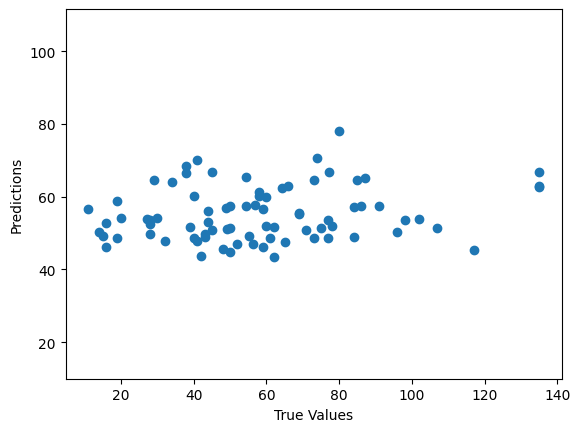

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

In [9]:
'''
Save the model to rfs_regression_model.pkl for later use in final predictions
'''
with open('rfs_regression_model.pkl', 'wb') as f:
  pickle.dump(best_rnd_forest, f)